In [25]:
#Shishir Khanal
#CMU-Optimal Controls from Jack Manchester
#Integrators-Discretization 
#Numerical solution of Marginally stable system using Forward Euler, Backward Euler and Runga-Kutta Algorithm
#For undamped systems, Euler will always blow up

In [26]:
import Pkg;
Pkg.activate(@__DIR__);
Pkg.instantiate();
Pkg.add("LinearAlgebra");
Pkg.add("PyPlot");
Pkg.add("ForwardDiff");

  Activating project at `~/Documents/Optimal_Control/Sims/Pend`
   Resolving package versions...
  No Changes to `~/Documents/Optimal_Control/Sims/Pend/Project.toml`
  No Changes to `~/Documents/Optimal_Control/Sims/Pend/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Documents/Optimal_Control/Sims/Pend/Project.toml`
  No Changes to `~/Documents/Optimal_Control/Sims/Pend/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Documents/Optimal_Control/Sims/Pend/Project.toml`
  No Changes to `~/Documents/Optimal_Control/Sims/Pend/Manifest.toml`


In [27]:
using LinearAlgebra;
using PyPlot;
using ForwardDiff;

In [28]:
#CT State Space representation of Simple Pendulum
function Simple_Pendulum(x)
    l = 1.0
    g = 9.81
    θ = x[1]
    θ_dot = x[2]
    θ_doubledot = -(g/l)*sin(θ)
    
    return [θ_dot;θ_doubledot]
end

Simple_Pendulum (generic function with 1 method)

In [29]:
Tf = 5
h = .1
t = Array(range(0, Tf, step=h))
x_hist = zeros(length(x0),length(t))
x_hist[:,1]

2-element Vector{Float64}:
 0.0
 0.0

In [30]:
#Forward Euler
#FE gives explicit update equation hence it is easier to implement practically
#Produce trajectory of states of simple pendulum 
function Pendulum_Forward_Euler(fun, x0, Tf, h)
    t = Array(0.0:h:Tf)
    x_hist = zeros(length(x0),length(t))
    x_hist[:,1] .= x0
    
    for k = 1:(length(t)-1)
        #yₙ₊₁ = yₙ + h*f(tₙ, yₙ)
        x_hist[:,k+1] .= x_hist[:,k] + h*fun(x_hist[:,k])
    end
    
    return x_hist, t
end

Pendulum_Forward_Euler (generic function with 1 method)

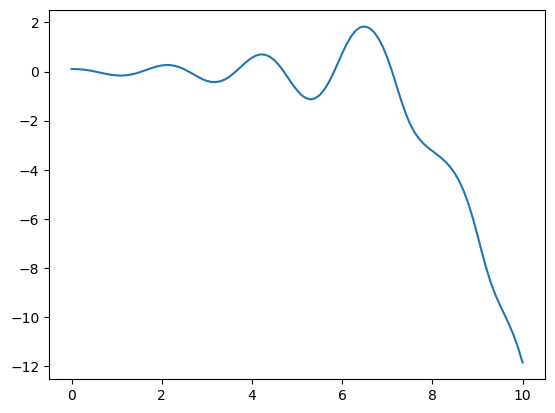

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f9e84645490>

In [31]:
#x = [θ; θ_dot]
x0 = [.1; 0]
#Final Time
Tf = 10
#Step time
h = .1
#produce the free response of pendulum
x_hist1, t_hist1 = Pendulum_Forward_Euler(Simple_Pendulum, x0, Tf, h)
plot(t_hist1, x_hist1[1,:])

In [32]:
#Stability analysis of DT pendulum ss equation
function Pendulum_Euler_Ad(x0, h)
    g = 9.81
    Ad = [1 h; -g*h*cos(x0[1]) 1]
end

Pendulum_Euler_Ad (generic function with 1 method)

In [33]:
#Evaluate eigenvalues of discrete A matrix
eigvals(Pendulum_Euler_Ad(0,0.1))

2-element Vector{ComplexF64}:
 1.0 - 0.31320919526731655im
 1.0 + 0.31320919526731655im

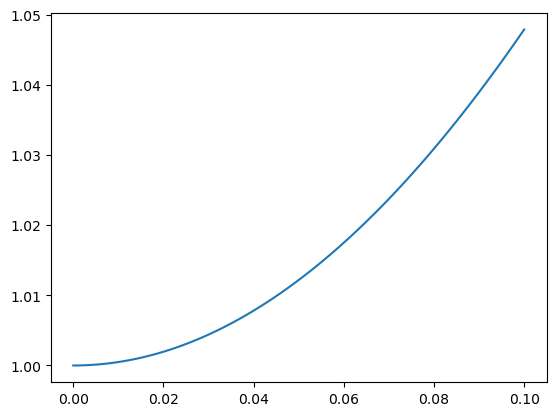

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f9e7b97ba90>

In [34]:
eignorm = zeros(100)
h = LinRange(0,0.1,100)
#How does discrete-time eigenvalues change as the sampling time is increased from 0 to 0.1Hz
for k = 1:length(eignorm)
    #Evaluate |eig(Ad)|
    eignorm[k] = max(norm.(eigvals(Pendulum_Euler_Ad([0;0], h[k])))...) 
end
#plot complex modulus
plot(h, eignorm)
#Forward Euler over estimates the magnitude of acceleration
#Root cause: Piecewise linear approximation in Euler Integrator
#Works best for systems that have high natural damping

In [63]:
#Now, try Runga-Kutta-4(Industry Standard)
#Integrator performs cubic interpolation
function fd_Pendulum_Rk4(xk, h)
    f1 = Simple_Pendulum(xk)
    f2 = Simple_Pendulum(xk + 0.5*h*f1)
    f3 = Simple_Pendulum(xk + 0.5*h*f2)
    f4 = Simple_Pendulum(xk + h*f3)
    return xk + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)    
end

fd_Pendulum_Rk4 (generic function with 1 method)

In [64]:
function Pendulum_RK4(fun, x0, Tf, h)
    t = Array(range(0,Tf,step=h))
    
    x_hist =zeros(length(x0),length(t))
    x_hist[:,1] .= x0
    for k = 1:(length(t)-1)
        x_hist[:,k+1] .= fd_Pendulum_Rk4(x_hist[:,k], h)
    end
    
    return x_hist, t
end

Pendulum_RK4 (generic function with 1 method)

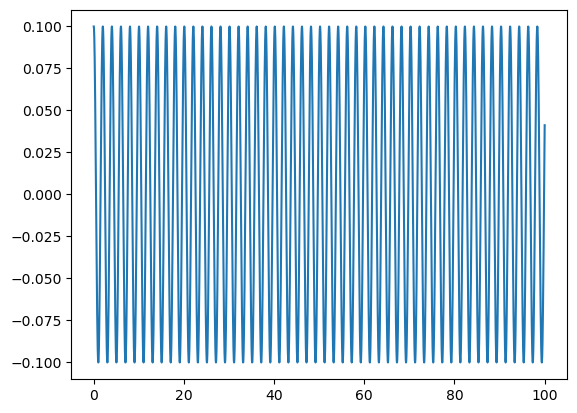

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f9e79e55430>

In [68]:
#x = [θ; θ_dot]
x0 = [.1; 0]
#True Behavior
x_hist2, t_hist2 = Pendulum_RK4(Simple_Pendulum,x0, 100,0.01)
plot(t_hist2, x_hist2[1,:])

In [59]:
using ForwardDiff
Ad = ForwardDiff.jacobian(x -> fd_Pendulum_Rk4(x, 0.1),[0; 0])
norm.(eigvals(Ad))

2-element Vector{Float64}:
 0.999993524288704
 0.999993524288704

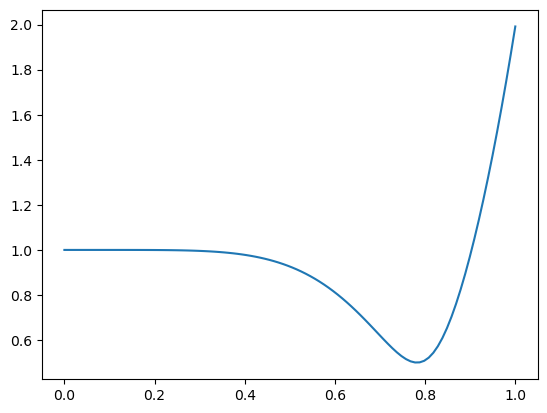

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f9e7a072c10>

In [60]:
#Magnitude of DT eigenvalues as sampling time is increased
eignorm = zeros(100)
h = LinRange(0, 1, 100)
for k = 1:length(eignorm)
    eignorm[k] = max(norm.(eigvals(ForwardDiff.jacobian(x -> fd_Pendulum_Rk4(x, h[k]), [0; 0])))...)
end
plot(h, eignorm)
#For some sampling time, the DT system will act damped due to some artificial damping
#and if sapling time is further increased, the system acts as if there is artificial energy increase
# and it will blow up

#from sampling time before 0.4, the mag of eigenvalues are 1. The undamped pendulum is a marginally stable system,
#hence sampling times in this range represents the physical system

In [61]:
#Backward Euler
#BE requires solving an implicit equation, better stability but computationally expensive
#BE artificially damps the system
function Pendulum_Backward_Euler(fun, x0, Tf, dt)
    t = Array(range(0, Tf, step=dt))
    
    x_hist = zeros(length(x0), length(t))
    x_hist[:,1] .= x0
    
    for k = 1:(length(t)-1)
        e = 1
        x_hist[:,k+1] = x_hist[:,k]
        while e > 1e-8
            xn = x_hist[:,k] + dt.*fun(x_hist[:,k+1])
            e = norm(xn - x_hist[:,k+1])
            x_hist[:,k+1] .= xn
        end
    end
    
    return x_hist, t
end

Pendulum_Backward_Euler (generic function with 1 method)

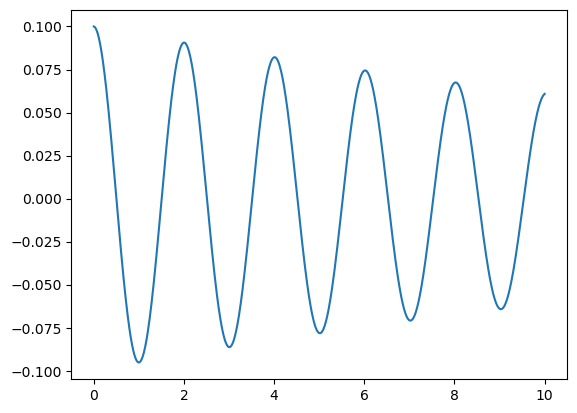

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f9e79febf70>

In [62]:
x0 = [.1; 0]
x_hist3, t_hist3 = Pendulum_Backward_Euler(Simple_Pendulum, x0, 10, 0.01)
plot(t_hist3, x_hist3[1,:])